In [ ]:
!pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 5.1 MB/s eta 0:00:00


In [ ]:
import copy
import os
import boto3
import traceback
import io
import json

import pandas as pd
import numpy as np

from botocore.exceptions import ClientError, NoCredentialsError
from traceback import format_exc

In [ ]:
os.environ['AWS_ACCESS_KEY_ID'] = <access_key>
os.environ['AWS_SECRET_ACCESS_KEY'] = <secret_access_key>

In [ ]:
BUCKET = 'russian-stocks-quotes'

access_key = os.getenv('AWS_ACCESS_KEY_ID')
secret_key = os.getenv('AWS_SECRET_ACCESS_KEY')
endpoint_url = 'https://storage.yandexcloud.net'

# Создание клиента S3
s3_client = boto3.client('s3',
                         region_name='ru-central1',
                         aws_access_key_id=access_key,
                         aws_secret_access_key=secret_key,
                         endpoint_url=endpoint_url)

def upload_object_to_s3(key, body):
    response = s3_client.put_object(Bucket=BUCKET, Key=key, Body=body)
    if response['ResponseMetadata']['HTTPStatusCode'] == 200:
        print(f"Успешно сохранен в {BUCKET}/{key}")
    else:
        print(f"Ошибка при сохранении: {response['ResponseMetadata']['HTTPStatusCode']}")

def upload_data_frame_to_s3(secid, data_frame, dir):
    pickle_buffer = io.BytesIO()
    data_frame.to_pickle(pickle_buffer)
    pickle_buffer.seek(0)
    data_frame_file = f'{dir}secids/{secid}/{secid}_data_frame.pkl'
    upload_object_to_s3(data_frame_file, pickle_buffer)

def upload_info_to_s3(secid, info, dir):
    info['miss_index'] = info['miss_index'].to_numpy().tolist()
    json_data = json.dumps(info)
    info_file = f'{dir}secids/{secid}/{secid}_info.pkl'
    upload_object_to_s3(info_file, json_data)

def upload_secid_names(dict_data, dir):
    json_data = json.dumps(list(dict_data.keys()))
    secid_names_file = f'{dir}secid_names.pkl'
    upload_object_to_s3(secid_names_file, json_data)

def upload_data_to_s3(dict_data, dir):
    try:
        upload_secid_names(dict_data, dir)
        for secid, data in dict_data.items():
            copy_data = copy.deepcopy(data)
            upload_data_frame_to_s3(secid, copy_data['data_frame'], dir)
            del copy_data['data_frame']
            upload_info_to_s3(secid, copy_data, dir)
    except ClientError as e:
        print(f"Произошла ошибка: {e.response['Error']['Message']}")
    except Exception as e:
        error_message = f"Неизвестная ошибка: {str(e)}"
        error_context = traceback.format_exc()
        print(f"{error_message}\nКонтекст ошибки:\n{error_context}")

def list_directories(s3_client):
    directories = set()
    try:
        paginator = s3_client.get_paginator('list_objects_v2')
        for page in paginator.paginate(Bucket=BUCKET, Delimiter='/'):
            for prefix in page.get('CommonPrefixes', []):
                directories.add(prefix.get('Prefix'))
    except NoCredentialsError:
        print("Ошибка: Неверные учетные данные.")
    except Exception as e:
        print(f"Произошла ошибка: {e}")
    return directories

def download_object_from_s3(key):
    response = s3_client.get_object(Bucket=BUCKET, Key=key)
    if response['ResponseMetadata']['HTTPStatusCode'] == 200:
        print(f"Успешно получен из {BUCKET}/{key}")
    else:
        print(f"Ошибка при получении: {response['ResponseMetadata']['HTTPStatusCode']}")
    return response['Body'].read()

def download_info_from_s3(dir, secid):
    key = f'{dir}secids/{secid}/{secid}_info.pkl'
    response = download_object_from_s3(key)
    data = json.loads(response)
    data['miss_index'] = pd.Index(np.array(data['miss_index']))
    return data

def download_data_frame_from_s3(dir, secid):
    key = f'{dir}secids/{secid}/{secid}_data_frame.pkl'
    response = download_object_from_s3(key)
    buffer = io.BytesIO(response)
    data = pd.read_pickle(buffer)
    data['TRADEDATE'] = pd.to_datetime(data['TRADEDATE'])
    return data

def download_secid_names(dir):
    key = f'{dir}secid_names.pkl'
    return json.loads(download_object_from_s3(key))

def download_data_from_s3(dir, secids=None):
    data = {}
    try:
        directories = download_secid_names(dir)
        for secid in directories:
            if secids is None or secid in secids:
                if secids is not None:
                    secids.remove(secid)
                data[secid] = download_info_from_s3(dir, secid)
                data[secid]['data_frame'] = download_data_frame_from_s3(dir, secid)
    except Exception as e:
        error_message = f"Неизвестная ошибка: {str(e)}"
        error_context = traceback.format_exc()
        print(f"{error_message}\nКонтекст ошибки:\n{error_context}")
    if secids is not None and len(secids) > 0:
        print(f'Не нашли {secids}')
    return data

In [ ]:
data_frames = download_data_from_s3('data_without_preprocessing/')

Успешно получен из russian-stocks-quotes/data_without_preprocessing/secid_names.pkl
Успешно получен из russian-stocks-quotes/data_without_preprocessing/secids/APRI/APRI_info.pkl
Успешно получен из russian-stocks-quotes/data_without_preprocessing/secids/APRI/APRI_data_frame.pkl
Успешно получен из russian-stocks-quotes/data_without_preprocessing/secids/KLVZ/KLVZ_info.pkl
Успешно получен из russian-stocks-quotes/data_without_preprocessing/secids/KLVZ/KLVZ_data_frame.pkl
Успешно получен из russian-stocks-quotes/data_without_preprocessing/secids/ASTR/ASTR_info.pkl
Успешно получен из russian-stocks-quotes/data_without_preprocessing/secids/ASTR/ASTR_data_frame.pkl
Успешно получен из russian-stocks-quotes/data_without_preprocessing/secids/ACKO/ACKO_info.pkl
Успешно получен из russian-stocks-quotes/data_without_preprocessing/secids/ACKO/ACKO_data_frame.pkl
Успешно получен из russian-stocks-quotes/data_without_preprocessing/secids/AVAZP/AVAZP_info.pkl
Успешно получен из russian-stocks-quotes/dat

Загрузим дополнительные библиотеки.

In [ ]:
import matplotlib.pyplot as plt

Посмотрим пропуски в данных.

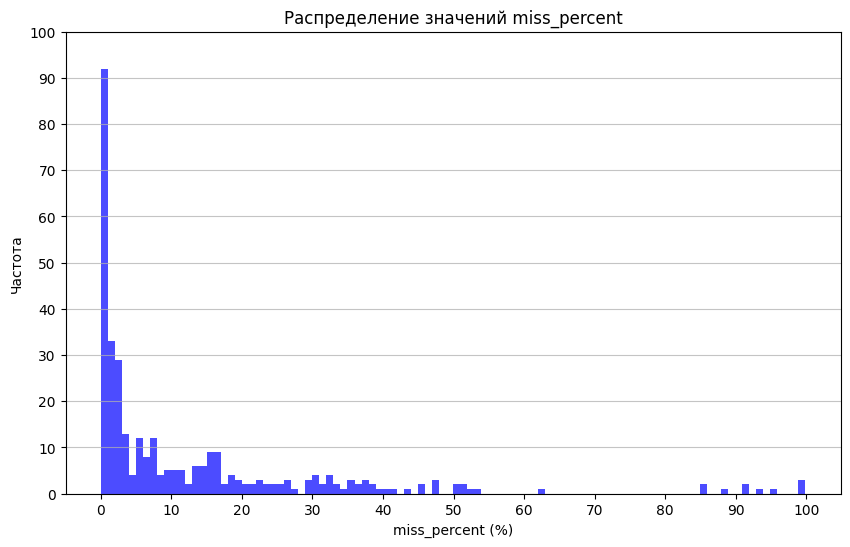

In [ ]:
miss_percents = [data['miss_percent'] for data in data_frames.values()]
miss_df = pd.DataFrame(miss_percents, columns=['miss_percent'])
plt.figure(figsize=(10, 6))
plt.hist(miss_df['miss_percent'], bins=100, color='blue', alpha=0.7)
plt.title('Распределение значений miss_percent')
plt.xlabel('Процент пропусков (%)')
plt.ylabel('Частота')
plt.xticks(np.arange(0, 101, step=10))
plt.yticks(np.arange(0, 101, step=10))
plt.grid(axis='y', alpha=0.75)
plt.show()

Можем посмотреть разницу цен между днями в абсолютном значении и в процентах.

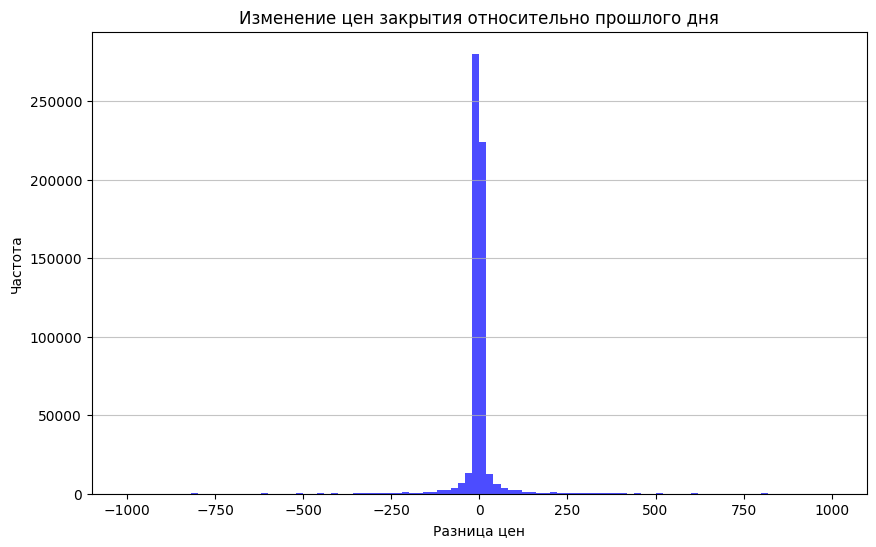

In [85]:
close_diffs = []
for secid, data in data_frames.items():
    close_diffs.extend([diff for diff in data['data_frame']['CLOSE'].dropna().diff()[1:]])
close_diffs = [item for item in close_diffs if item > -1000 and item < 1000]
plt.figure(figsize=(10, 6))
plt.hist(close_diffs, bins=100, color='blue', alpha=0.7)
plt.title('Изменение цен закрытия относительно прошлого дня')
plt.xlabel('Разница цен')
plt.ylabel('Частота')
plt.grid(axis='y', alpha=0.75)
plt.show()

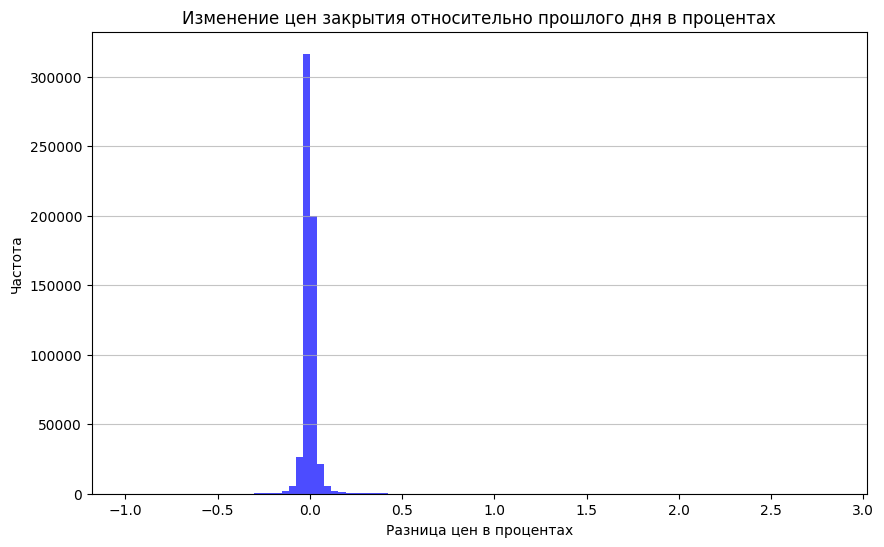

In [78]:
close_diffs = []
for secid, data in data_frames.items():
    close_diffs.extend([diff for diff in data['data_frame']['CLOSE'].dropna().pct_change()[1:]])
close_diffs = [item for item in close_diffs if item < 10]
plt.figure(figsize=(10, 6))
plt.hist(close_diffs, bins=100, color='blue', alpha=0.7)
plt.title('Изменение цен закрытия относительно прошлого дня в процентах')
plt.xlabel('Разница цен в процентах')
plt.ylabel('Частота')
plt.grid(axis='y', alpha=0.75)
plt.show()

Какой-то зависимости так через график незаметно.

Обработаем данные удалив начальные пропуски, которые не будут полезны.

In [87]:
def find_first_normal_index(data):
    full_index = np.arange(0, data['data_frame'].shape[0] + 1)
    missing_values = np.setdiff1d(full_index, data['miss_index'])
    return missing_values[0]

filtered_data_frames = copy.deepcopy(data_frames)
for secid, data in filtered_data_frames.items():
    first_not_missed = find_first_normal_index(data)
    if first_not_missed != 0:
        data['data_frame'] = data['data_frame'].iloc[first_not_missed:]
        data['data_frame'].reset_index(drop=True, inplace=True)
        data['miss_index'] = data['miss_index'][data['miss_index'] >= first_not_missed] - first_not_missed
        data['miss_count'] = int(data['miss_count'] - first_not_missed)
        data['row_count'] = int(data['row_count'] - first_not_missed)
        data['miss_percent'] = float(data['miss_count'] / data['row_count'] * 100)

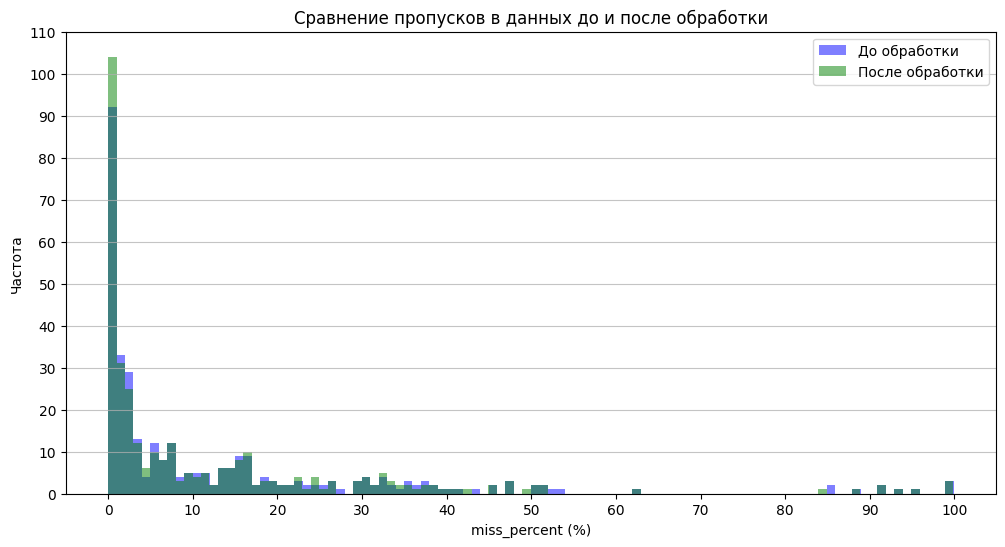

In [91]:
miss_percents_before = [data['miss_percent'] for data in data_frames.values()]
miss_percents_after = [data['miss_percent'] for data in filtered_data_frames.values()]

miss_df_before = pd.DataFrame(miss_percents_before, columns=['miss_percent'])
miss_df_after = pd.DataFrame(miss_percents_after, columns=['miss_percent'])

plt.figure(figsize=(12, 6))
plt.hist(miss_df_before['miss_percent'], bins=100, color='blue', alpha=0.5, label='До обработки')
plt.hist(miss_df_after['miss_percent'], bins=100, color='green', alpha=0.5, label='После обработки')

plt.title('Сравнение пропусков в данных до и после обработки')
plt.xlabel('miss_percent (%)')
plt.ylabel('Частота')
plt.xticks(np.arange(0, 101, step=10))
plt.yticks(np.arange(0, 111, step=10))
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

Как можно увидеть немного удалось улучшить. Чуть больше 10 таблиц удалось если не полностью избавить от пропусков, то приблизить к 0.

In [93]:
diffs = [item for item in miss_df_before['miss_percent'] - miss_df_after['miss_percent'] if item > 0.00001]
print(f"Средний процент пропусков до: {miss_df_before['miss_percent'].mean()}")
print(f"Средний проуент пропусков после: {miss_df_after['miss_percent'].mean()}")
print(f'Минимальное улучшение: {min(diffs)}%, Самое удачное: {max(diffs)}%')

Средний процент пропусков до: 12.808210053209585
Средний проуент пропусков после: 12.181561590135022
Минимальное улучшение: 0.008031681035475913%, Самое удачное: 84.40332507585359%


Дальше приведено изменение числа данных для каждой бумаги.

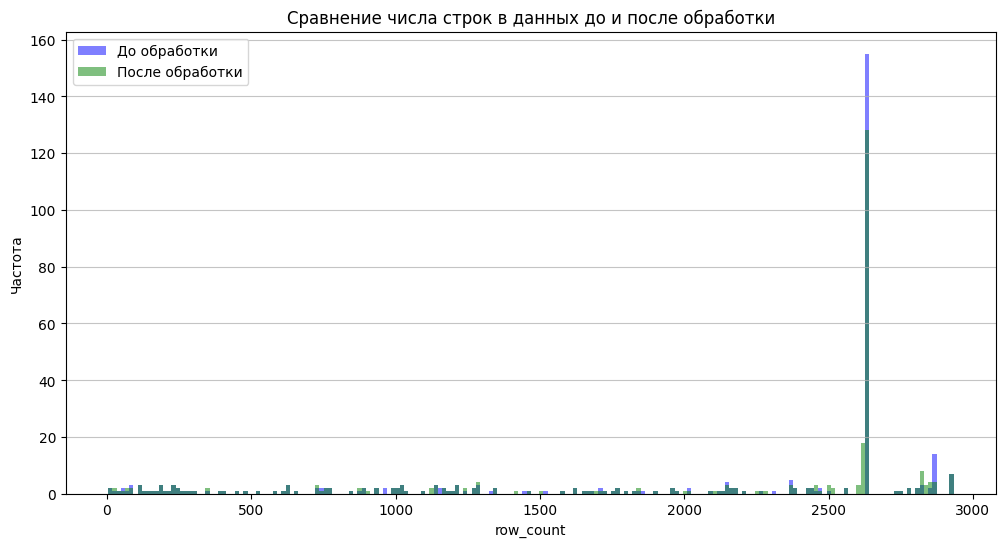

In [97]:
row_counts_before = [data['row_count'] for data in data_frames.values()]
row_counts_after = [data['row_count'] for data in filtered_data_frames.values()]

row_df_before = pd.DataFrame(row_counts_before, columns=['row_count'])
row_df_after = pd.DataFrame(row_counts_after, columns=['row_count'])

plt.figure(figsize=(12, 6))
plt.hist(row_df_before['row_count'], bins=200, color='blue', alpha=0.5, label='До обработки')
plt.hist(row_df_after['row_count'], bins=200, color='green', alpha=0.5, label='После обработки')

plt.title('Сравнение числа строк в данных до и после обработки')
plt.xlabel('row_count')
plt.ylabel('Частота')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

Для нормального предсказания буду брать данные с пропуском не более 10%.

In [96]:
normal_start_dataframe_data = {secid: data for secid, data in filtered_data_frames.items() if data['miss_percent'] <= 10}
len(normal_start_dataframe_data)

216

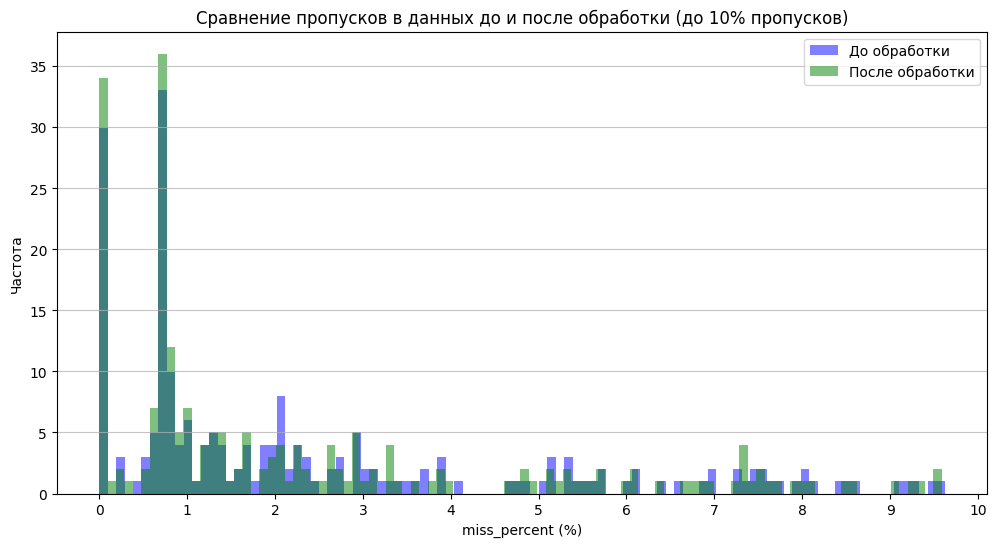

In [106]:
miss_percents_before = [data['miss_percent'] for data in data_frames.values() if data['miss_percent'] <= 10]
miss_percents_after = [data['miss_percent'] for data in normal_start_dataframe_data.values()]

miss_df_before = pd.DataFrame(miss_percents_before, columns=['miss_percent'])
miss_df_after = pd.DataFrame(miss_percents_after, columns=['miss_percent'])

plt.figure(figsize=(12, 6))
plt.hist(miss_df_before['miss_percent'], bins=100, color='blue', alpha=0.5, label='До обработки')
plt.hist(miss_df_after['miss_percent'], bins=100, color='green', alpha=0.5, label='После обработки')

plt.title('Сравнение пропусков в данных до и после обработки (до 10% пропусков)')
plt.xlabel('miss_percent (%)')
plt.ylabel('Частота')
plt.xticks(np.arange(0, 11, step=1))
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

In [107]:
upload_data_to_s3(normal_start_dataframe_data, 'normal_start/')

Успешно сохранен в russian-stocks-quotes/normal_start/secid_names.pkl
Успешно сохранен в russian-stocks-quotes/normal_start/secids/APRI/APRI_data_frame.pkl
Успешно сохранен в russian-stocks-quotes/normal_start/secids/APRI/APRI_info.pkl
Успешно сохранен в russian-stocks-quotes/normal_start/secids/KLVZ/KLVZ_data_frame.pkl
Успешно сохранен в russian-stocks-quotes/normal_start/secids/KLVZ/KLVZ_info.pkl
Успешно сохранен в russian-stocks-quotes/normal_start/secids/ASTR/ASTR_data_frame.pkl
Успешно сохранен в russian-stocks-quotes/normal_start/secids/ASTR/ASTR_info.pkl
Успешно сохранен в russian-stocks-quotes/normal_start/secids/AVAZP/AVAZP_data_frame.pkl
Успешно сохранен в russian-stocks-quotes/normal_start/secids/AVAZP/AVAZP_info.pkl
Успешно сохранен в russian-stocks-quotes/normal_start/secids/AVAZ/AVAZ_data_frame.pkl
Успешно сохранен в russian-stocks-quotes/normal_start/secids/AVAZ/AVAZ_info.pkl
Успешно сохранен в russian-stocks-quotes/normal_start/secids/DATA/DATA_data_frame.pkl
Успешно со